In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

In [2]:
nels = pd.read_csv('data/NELS_Filtered.csv')
nels_columns = pd.read_csv('data/NELS_Subset_Columns.csv')
nels_columns_readable = pd.read_csv('data/NELS_Subset_Columns_Human_Readable.csv')
nels_subset = nels[list(nels_columns.columns)]
nels_subset.columns = list(nels_columns_readable.columns)

In [3]:
target_col = "GradesUndergrad" # Grades
nels_valid_grades = nels_subset[(1 <= nels_subset[target_col]) & (nels_subset[target_col] <= 7)]

# Make binary decision >= 2.75 GPA
nels_valid_grades[target_col] = np.where(nels_valid_grades[target_col] <= 3, 1, 0)

# Shuffle randomly before training models
nels_valid_grades = nels_valid_grades.sample(frac=1).reset_index(drop=True)

# Withhold columns that are improper for prediction (like having completed PSE)
columns_to_withhold = ["Degree", 
"StudentId", 
"HighestPostSecondaryEducationAttained", 
"AttendedFirstChoicePostSecondaryEducation",
"JobSatisfaction", 
"Income",
"TotalEarningsJob1",
"TotalEarningsJob2",
"CoursesAt2To4YearCollege"]
nels_valid_grades = nels_valid_grades[nels_valid_grades.columns.difference(columns_to_withhold)]

X = nels_valid_grades[nels_valid_grades.columns.difference([target_col])]
y = nels_valid_grades[target_col]


/var/folders/qj/gh_j11514m37mqtfrlr885k40000gn/T/ipykernel_74865/2138916466.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nels_valid_grades[target_col] = np.where(nels_valid_grades[target_col] <= 3, 1, 0)


In [4]:
# Run this cell to downsample
from sklearn.utils import resample
upsample = True

# Separate majority and minority classes
df_majority = nels_valid_grades[nels_valid_grades[target_col]==1]
df_minority = nels_valid_grades[nels_valid_grades[target_col]==0]

if upsample:
    # Upsample minority class
    df_minority_upsampled = resample(df_minority, 
                                    replace=True,
                                    n_samples=6640,
                                    random_state=0)
 
    # Combine majority class with upsampled minority class
    df_resampled = pd.concat([df_majority, df_minority_upsampled])
else:
    # Downsample majority class
    df_majority_downsampled = resample(df_majority, 
                                    replace=False,
                                    n_samples=1699,
                                    random_state=0) 
    
    # Combine minority class with downsampled majority class
    df_resampled = pd.concat([df_majority_downsampled, df_minority])
    
# Display new class counts
df_resampled[target_col].value_counts()
nels_valid_grades = df_resampled

X = nels_valid_grades.loc[:, nels_valid_grades.columns != target_col]
y = nels_valid_grades[target_col]

In [5]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [6]:
rf = RandomForestClassifier() # max_iter=1000 
rf.fit(x_train, y_train)


RandomForestClassifier()

In [7]:
predictions = rf.predict(x_test)

In [8]:
print(classification_report(y_test, predictions)) # target_names=target_names

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      2039
           1       0.94      0.92      0.93      1945

    accuracy                           0.93      3984
   macro avg       0.93      0.93      0.93      3984
weighted avg       0.93      0.93      0.93      3984



In [11]:
rf_cross = RandomForestClassifier()
scores = cross_val_score(rf, X, y, cv=5)
scores

array([0.95331325, 0.95444277, 0.95745482, 0.9559488 , 0.94728916])

/Users/lucasrosenblatt/opt/miniconda3/envs/fairness_aif/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


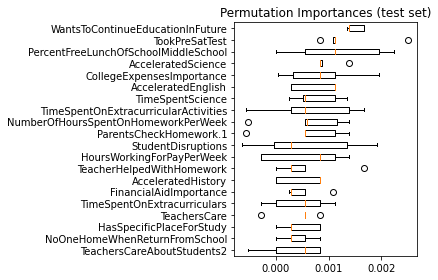

In [10]:
result = permutation_importance(
    rf, x_test, y_test, n_repeats=5, random_state=0, n_jobs=5, max_samples=1.0, scoring='f1'
)
sorted_idx = result.importances_mean.argsort()[-20:]

fig, ax = plt.subplots()
ax.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=x_test.columns[sorted_idx]
)
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()
